In [2]:
suppressPackageStartupMessages(library(dplyr)) 
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(harmony))

library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(repr)

source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

In [ ]:
gene_meta <- read.table("/projects//ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.gcode.10X.bed")

## Reference map DHC data

In [4]:
library(anndata)
intobj <- read_h5ad("/projects//ps-renlab2/y2xie/projects/77.LC/87.FNIH_DHC_IGM_240925/05.R/integration/FNIH_DHC_genescore_joint_embedding.h5ad")
obj1 <- qs::qread("/projects//ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/05.R/integration/CAREHF_Multiome_DPT_RNA_int.obj.qs")

In [ ]:
### mock seurat data
gene3c <- Matrix::readMM("../../87.FNIH_DHC_IGM_240925/05.R/integration/FNIH_DHC_genescore.mtx")
barcodes <- read.csv("../../87.FNIH_DHC_IGM_240925/05.R/integration/FNIH_DHC_genescore.barcodes.csv", header = F)
features <- read.csv("../../87.FNIH_DHC_IGM_240925/05.R/integration/FNIH_DHC_genescore.features.csv", header = F)
rownames(gene3c) <- barcodes$V2
colnames(gene3c) <- features$V2
colnames(gene3c) <- gene_meta[match(colnames(gene3c), gene_meta$V5),]$V6

In [ ]:
### make gene name unique 
unique_genes <- unique(colnames(gene3c))
duplicated_indices <- which(duplicated(colnames(gene3c)) | duplicated(colnames(gene3c), fromLast = TRUE))
gene3cc <- gene3c[, -duplicated_indices]
gene3c <- CreateSeuratObject(t(gene3cc))

In [ ]:
### Addin pre-computed embedding
tmp <- (intobj$obsm$cca[(intobj$obs_names %in% colnames(obj1)),])
rownames(tmp) <- intobj$obs_names[intobj$obs_names %in% colnames(obj1)]
obj1[["cca"]] <- CreateDimReducObject(embeddings = tmp, key = "CCA")

tmp <- (intobj$obsm$cca[(intobj$obs_names %in% colnames(gene3c)),])
rownames(tmp) <- intobj$obs_names[intobj$obs_names %in% colnames(gene3c)]
gene3c[["cca"]] <- CreateDimReducObject(embeddings = tmp, key = "CCA")

In [ ]:
### ProjectUMAP
gene3c <- ProjectUMAP(query = gene3c, query.dims = 1:30, reference = obj1, reference.dims = 1:30, 
            reference.reduction = 'cca', query.reduction = 'cca', reduction.model = "umap", k.param = 30)

In [ ]:
sinfo <- read.table("../../87.FNIH_DHC_IGM_240925/05.R/FNIH_Heart_DHC_demultiplex_SNG.summary", header = T)
rownames(sinfo) <- paste0(sinfo$LIBRARY, "_", sinfo$Row.names)
donor_info <- read.table('../../81.FNIH_DPT_IGM_240827/reference/CAREHF_FNIH_donor.simple.info', sep = "\t", row.names = 1, header = T)
gene3c@meta.data[, colnames(sinfo)] <- sinfo[colnames(gene3c),]
gene3c$Donor <- gsub(".*-([^-]+)$", "\\1", gene3c$SNG.BEST.GUESS)
gene3c@meta.data[, colnames(donor_info)] <- donor_info[match(gene3c$Donor, donor_info$Patient.ID), ]

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



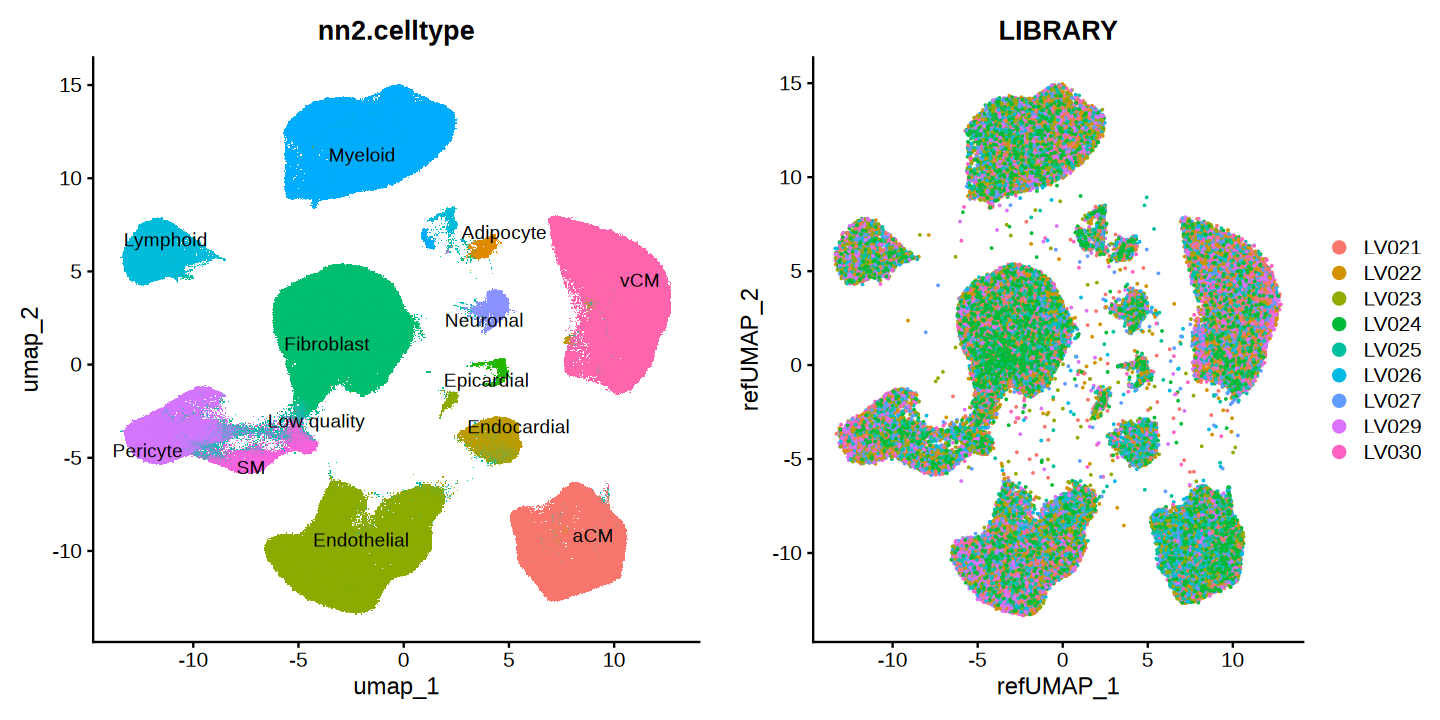

In [10]:
gene3c$logGene <- log10(gene3c$nCount_RNA)

t1 <- DimPlot(obj1, label = T, repel = T, group.by = "nn2.celltype") + NoLegend()
t2 <- DimPlot(gene3c, group.by = "LIBRARY", reduction = "ref.umap")

options(repr.plot.width = 12, repr.plot.height = 6)
cowplot::plot_grid(t1, t2)

In [12]:
### Read prediction results
pred <- read.csv('/projects//ps-renlab2/y2xie/projects/77.LC/87.FNIH_DHC_IGM_240925/05.R/integration/FNIH_DHC_genescore_prediction.metadata.csv', row.names = 1)
gene3c@meta.data[, colnames(pred)] <- pred[colnames(gene3c),]

In [13]:
table(pred$predicted.score > 0.95)/nrow(pred)
table(pred$predicted.score > 0.9)/nrow(pred)
table(pred$predicted.score > 0.85)/nrow(pred)


   FALSE     TRUE 
0.111304 0.888696 


     FALSE       TRUE 
0.09284904 0.90715096 


     FALSE       TRUE 
0.07776646 0.92223354 

## Write Droplet Hi-C cell type prediction

[1] 69683

[1] 61927

[1] 63134

[1] 63143

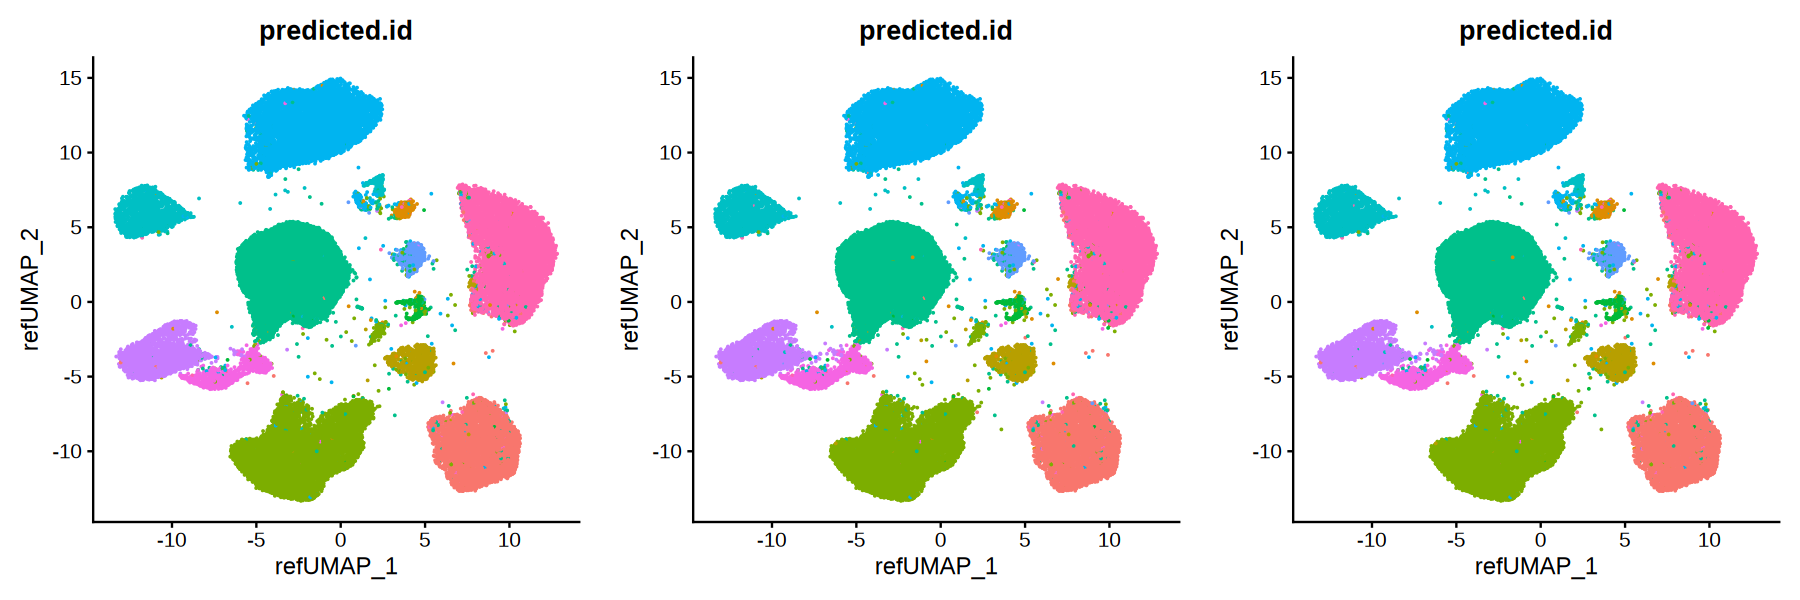

In [15]:
gene3c@meta.data %>% nrow
gene3c@meta.data %>% filter(predicted.score >= 0.95) %>% nrow
gene3c@meta.data %>% filter(predicted.score >= 0.9 & cis_1kb..1 > 500) %>% nrow
gene3c@meta.data %>% filter(predicted.score >= 0.9 & nCount_RNA > 500) %>% nrow

options(repr.plot.width = 15, repr.plot.height = 5)
t1 <- DimPlot(gene3c, group.by = "predicted.id", reduction = "ref.umap", 
              cells = rownames(gene3c@meta.data[gene3c$predicted.score > 0.95, ])) + NoLegend()
t2 <- DimPlot(gene3c, group.by = "predicted.id", reduction = "ref.umap", 
              cells = rownames(gene3c@meta.data[gene3c$predicted.score > 0.9 & gene3c$cis_1kb..1 > 500, ])) + NoLegend()
t3 <- DimPlot(gene3c, group.by = "predicted.id", reduction = "ref.umap", 
              cells = rownames(gene3c@meta.data[gene3c$predicted.score > 0.9 & gene3c$nCount_RNA > 500, ])) + NoLegend()

cowplot::plot_grid(t1, t2, t3, ncol = 3)

In [ ]:
### for scHiCluster
qmeta <- gene3c@meta.data %>% filter(predicted.score >= 0.9 & nCount_RNA > 500 & cis_1kb..1 > 500)
i100 <- read.table("../../87.FNIH_DHC_IGM_240925/impute//impute_100k.txt", row.names = 1)
i25 <- read.table("../../87.FNIH_DHC_IGM_240925/impute//impute_25k.txt", row.names = 1)
i10 <- read.table("../../87.FNIH_DHC_IGM_240925/impute//impute_10k.txt", row.names = 1)
for (f in unique(qmeta$predicted.id)){
    cells <- qmeta %>% filter(predicted.id == f) %>% rownames
    write.table(i100[cells,], paste0("../../87.FNIH_DHC_IGM_240925/impute/celltype_100k/", f, ".txt"), 
                sep = "\t", quote = F, row.names = F, col.names = F)
    write.table(i25[cells,], paste0("../../87.FNIH_DHC_IGM_240925/impute/celltype_25k/", f, ".txt"), 
                sep = "\t", quote = F, row.names = F, col.names = F)
    write.table(i10[cells,], paste0("../../87.FNIH_DHC_IGM_240925/impute/celltype_10k/", f, ".txt"), 
                sep = "\t", quote = F, row.names = F, col.names = F)
}

In [ ]:
qmeta$condition2 <- paste0(qmeta$predicted.id, "_", qmeta$condition)
for (f in unique(qmeta$condition2)){
    cells <- qmeta %>% filter(condition2 == f) %>% rownames
    write.table(i100[cells,], paste0("../../87.FNIH_DHC_IGM_240925/impute/celltype_100k/", f, ".txt"), 
                sep = "\t", quote = F, row.names = F, col.names = F)
    write.table(i25[cells,], paste0("../../87.FNIH_DHC_IGM_240925/impute/celltype_25k/", f, ".txt"), 
                sep = "\t", quote = F, row.names = F, col.names = F)
    write.table(i10[cells,], paste0("../../87.FNIH_DHC_IGM_240925/impute/celltype_10k/", f, ".txt"), 
                sep = "\t", quote = F, row.names = F, col.names = F)
}

In [ ]:
write.table(qmeta, "../../87.FNIH_DHC_IGM_240925/05.R/integration/FNIH_DHC_annotation.filter.txt", 
            sep = "\t", quote = F, row.names = T, col.names = T)

In [ ]:
### write raw cells
rmbl <- read.table("../../87.FNIH_DHC_IGM_240925/impute/all_cell_rmbl.txt", row.names = 1)
system("mkdir ../../87.FNIH_DHC_IGM_240925/impute/celltype_raw")
for (f in unique(qmeta$predicted.id)){
    cells <- qmeta %>% filter(predicted.id == f) %>% rownames
    write.table(rmbl[cells,], paste0("../../87.FNIH_DHC_IGM_240925/impute/celltype_raw/", f, ".txt"), 
                sep = "\t", quote = F, row.names = T, col.names = F)
}

for (f in unique(qmeta$condition2)){
    cells <- qmeta %>% filter(condition2 == f) %>% rownames
    write.table(rmbl[cells,], paste0("../../87.FNIH_DHC_IGM_240925/impute/celltype_raw/", f, ".txt"), 
                sep = "\t", quote = F, row.names = T, col.names = F)
}

## Create integration objects from all modalities

In [ ]:
tmp <- subset(gene3c, cells = rownames(qmeta))
obj1 <- merge(obj, tmp) 

obj1@meta.data[colnames(gene3c), ]$orig.ident <- "DHC"
obj1@meta.data[colnames(obj), ]$nn2.celltype <- obj$nn2.celltype
obj1@meta.data[colnames(gene3c), ]$nn2.celltype <- gene3c$predicted.id

qs::qsave(obj1, "../../87.FNIH_DHC_IGM_240925/05.R/integration/All_data.int.qs")

In [28]:
### Add UMAP
obj2 <- CreateSeuratObject(obj1@assays$SCT@counts, meta.data = obj1@meta.data)
eb1 <- gene3c@reductions$ref.umap@cell.embeddings %>% 
as.data.frame %>% setNames(c("V1", "V2"))
eb2 <- obj@reductions$umap@cell.embeddings %>% 
as.data.frame %>% setNames(c("V1", "V2"))
ebed <- rbind(eb1, eb2)[colnames(obj1), 1:2] %>% setNames(c("UMAP_1", "UMAP2"))

obj2[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(ebed), key = "UMAP_", assay = "RNA")

obj2

An object of class Seurat 
36100 features across 776474 samples within 1 assay 
Active assay: RNA (36100 features, 0 variable features)
 1 layer present: counts
 1 dimensional reduction calculated: umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


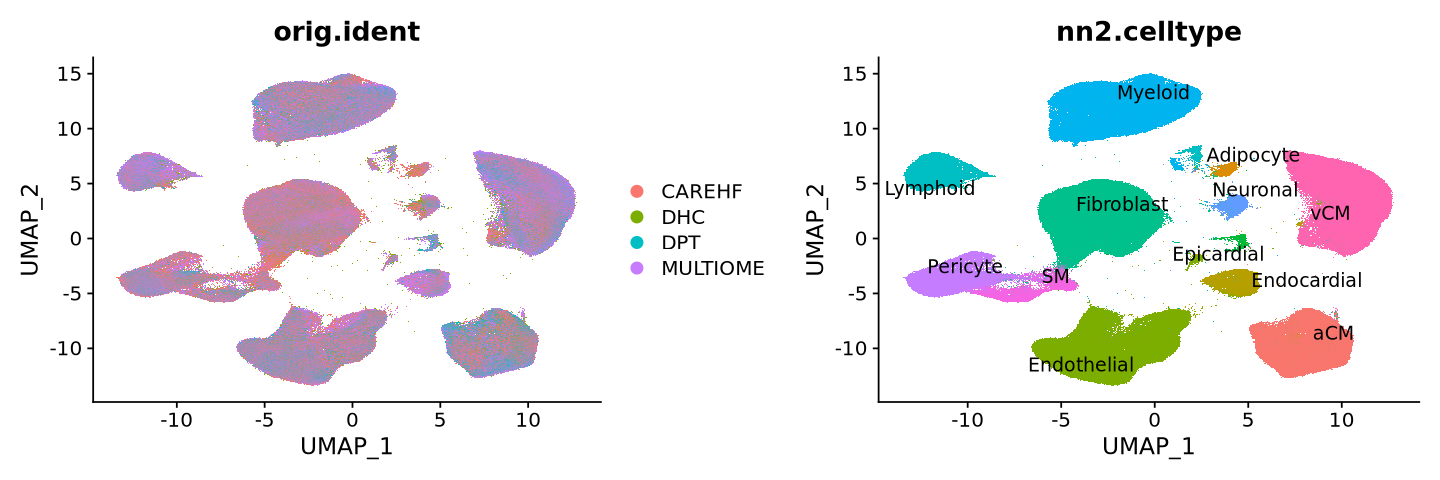

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



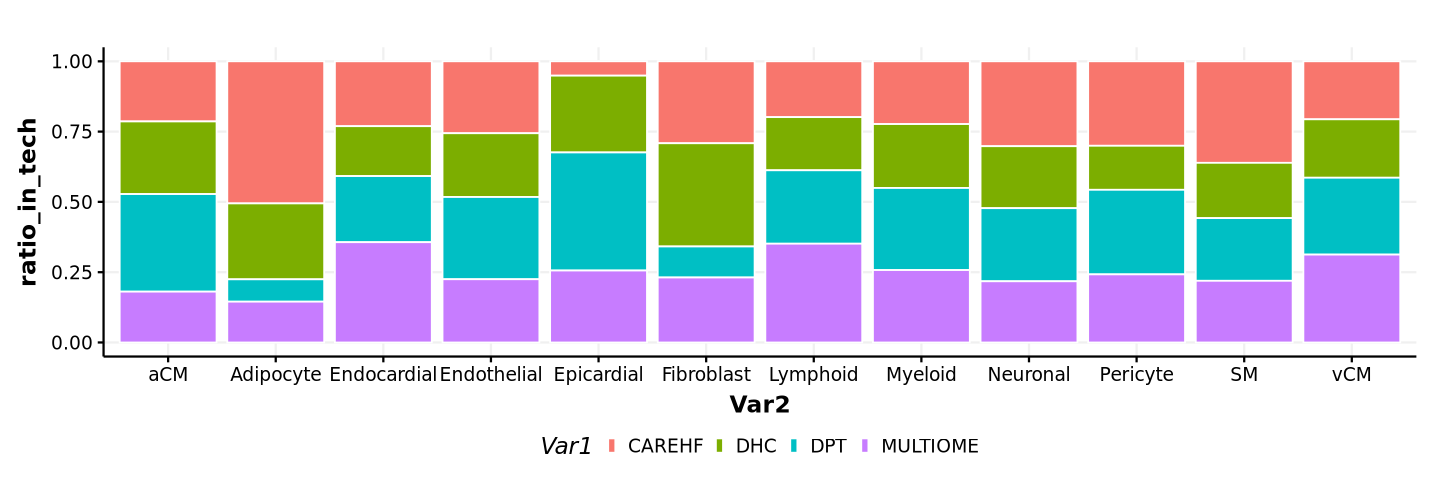

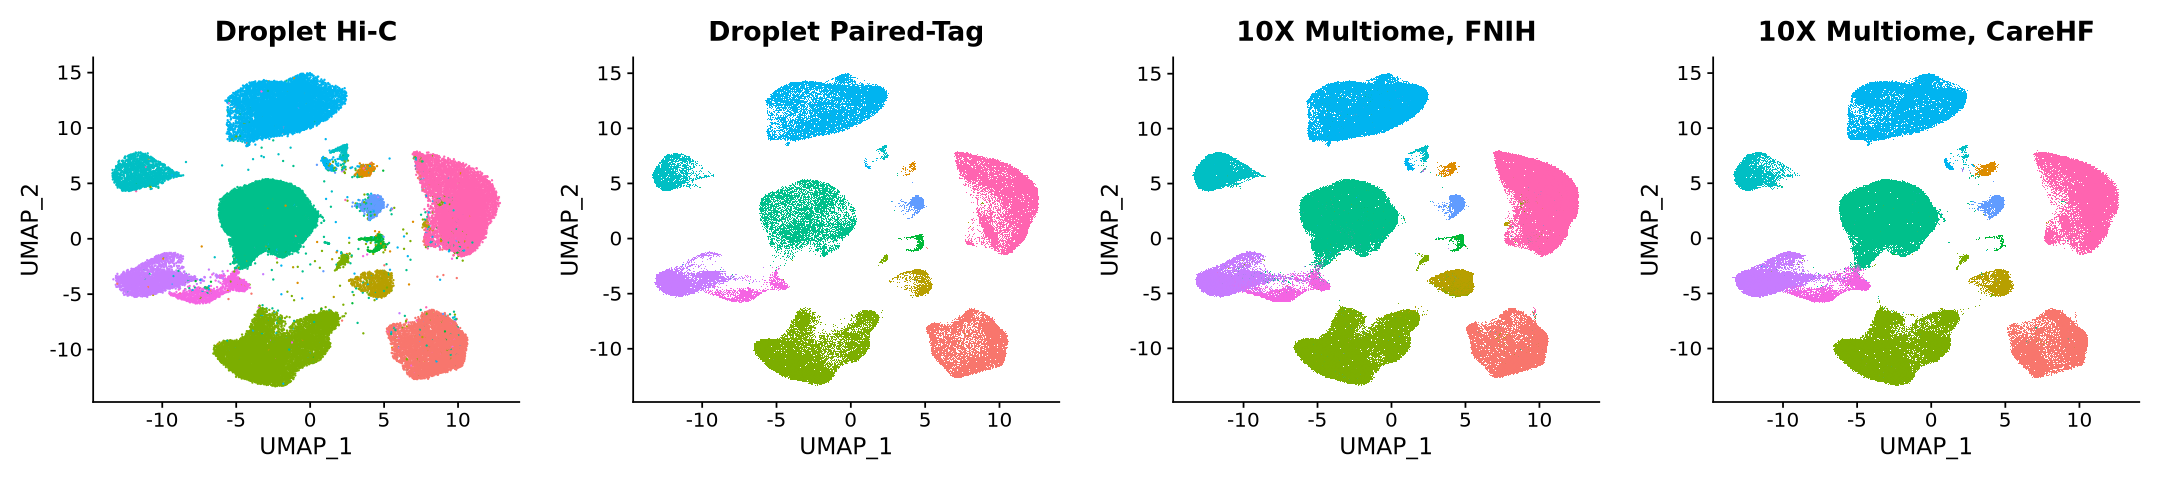

In [27]:
options(repr.plot.width = 12, repr.plot.height = 4)

t1 <- DimPlot(obj2, group.by = 'orig.ident')
t2 <- DimPlot(obj2, group.by = "nn2.celltype", label = T, repel = T) + NoLegend()
fig1 <- cowplot::plot_grid(t1, t2, rel_widths = c(1.2, 1))

fig1

options(repr.plot.width = 12, repr.plot.height = 4)
table(obj2$orig.ident, obj2$nn2.celltype) %>%
as.data.frame %>% group_by(Var1) %>% mutate(ratio_in_tech = Freq / sum(Freq)) %>%
ungroup() %>%
ggplot(aes(x = Var2, y = ratio_in_tech, fill = Var1)) + 
geom_col(position = "fill", color = "white") + 
theme_Publication()

options(repr.plot.width = 18, repr.plot.height = 4)

t1 <- DimPlot(obj2, group.by = 'nn2.celltype', cells = rownames(obj2@meta.data[obj2$orig.ident == "DHC", ]),
              label = F, repel = T) + NoLegend() + ggtitle("Droplet Hi-C") #+ scale_color_manual(values = "#2EA7E0")
t2 <- DimPlot(obj2, group.by = 'nn2.celltype', cells = rownames(obj2@meta.data[obj2$orig.ident == "DPT", ]),
              label = F, repel = T) + NoLegend() + ggtitle("Droplet Paired-Tag") #+ scale_color_manual(values = "#956134")
t3 <- DimPlot(obj2, group.by = 'nn2.celltype', cells = rownames(obj2@meta.data[obj2$orig.ident == "MULTIOME", ]),
              label = F, repel = T) + NoLegend() + ggtitle("10X Multiome, FNIH") #+ scale_color_manual(values = "#727171")
t4 <- DimPlot(obj2, group.by = 'nn2.celltype', cells = rownames(obj2@meta.data[obj2$orig.ident == "CAREHF", ]),
              label = F, repel = T) + NoLegend() + ggtitle("10X Multiome, CareHF") #+ scale_color_manual(values = "#727171")

cowplot::plot_grid(t1, t2, t3, t4, ncol = 4)

In [29]:
qs::qsave(obj2, "../../87.FNIH_DHC_IGM_240925/05.R/integration/All_data.int.qs")